In [35]:
import Playlist_Class as PC
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
focus_playlists = PC.SpotifyPlaylist('focus', 'US', 15).tracks
workout_playlists = PC.SpotifyPlaylist('workout', 'US', 15).tracks
sleep_playlists = PC.SpotifyPlaylist('mood', 'US', 15).tracks
party_playlists = PC.SpotifyPlaylist('party', 'US', 15).tracks

BARK BARK BARK >:(
BARK BARK BARK >:(


Before concatenating all of our playlists into one big dataframe, we have to make sure that we label each song with its corresponding playlist. These categories will be our target column for classification

In [3]:
focus_playlists['playlist_type'] = ['focus']*len(focus_playlists)
workout_playlists['playlist_type'] = ['workout']*len(workout_playlists)
sleep_playlists['playlist_type'] = ['sleep']*len(sleep_playlists)
party_playlists['playlist_type'] = ['party']*len(party_playlists)

In [4]:
playlists = pd.concat([focus_playlists, workout_playlists, sleep_playlists, party_playlists])
len(playlists)

4244

Now that we've concatenated our data into one big playlist, we have to check one very important detail; whether tracks show up in multiple different types of playlists

In [5]:
playlists[playlists.duplicated(subset=['name', 'artists'], keep=False)].name.nunique()

285

First we query all songs in our playlist that are duplicated. Then using nunique we see that there are 284 songs that are repeated in at least one playlist. We have to decide what to do with these songs. 

It would be interesting to do some type of multilabel output classification. However, to do this I would need a more conclusive lists of tracks, since I can't verify which playlists a song belongs in without first getting a list of every track in each of the playlists present.

To keep things simple, it might be better to discard these border cases, and revisit the idea of a multilabel output in a cloud setting instead, so that I have the memory to fit all of the data and run computations.

In [6]:
playlists.drop_duplicates(subset=['name', 'artists'], inplace=True, keep=False)

In [7]:
assert not any(playlists.duplicated(subset=['name', 'artists'], keep=False))

In [8]:
len(playlists)

3626

We've dropped about 600 records from our dataset. The border cases may still be present for the reason i mentioned earlier; We can't be sure if a track is present in another playlist type without getting every track from every playlist of all present playlist. Keeping this in mind let's proceed to the next part of our analysis.

# Preliminary Data Exploration

In [11]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3626 entries, 5z7sxlo3kf8eg8s3Zkb8dQ to 6lEAYlnuzxr0HHzdzXjBmx
Data columns (total 19 columns):
name                3626 non-null object
artists             3626 non-null object
album               3626 non-null object
duration_ms         3626 non-null int64
popularity          3626 non-null int64
acousticness        3626 non-null float64
danceability        3626 non-null float64
energy              3626 non-null float64
instrumentalness    3626 non-null float64
key                 3626 non-null category
liveness            3626 non-null float64
loudness            3626 non-null float64
mode                3626 non-null category
speechiness         3626 non-null float64
tempo               3626 non-null float64
time_signature      3626 non-null int64
valence             3626 non-null float64
rating              3626 non-null category
playlist_type       3626 non-null object
dtypes: category(3), float64(9), int64(3), object(4)
memory usage: 4

We see that we have 3626 entries, all non-null, and we have a good mix of categorical and numerical columns. We also see that our playlist_type column is of type object, let's make it of type category, since categorical variables take up less memory than string variables ( because of how pandas treats categorical vs object types)

In [12]:
playlists['playlist_type'] = playlists['playlist_type'].astype('category')

In [14]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3626 entries, 5z7sxlo3kf8eg8s3Zkb8dQ to 6lEAYlnuzxr0HHzdzXjBmx
Data columns (total 19 columns):
name                3626 non-null object
artists             3626 non-null object
album               3626 non-null object
duration_ms         3626 non-null int64
popularity          3626 non-null int64
acousticness        3626 non-null float64
danceability        3626 non-null float64
energy              3626 non-null float64
instrumentalness    3626 non-null float64
key                 3626 non-null category
liveness            3626 non-null float64
loudness            3626 non-null float64
mode                3626 non-null category
speechiness         3626 non-null float64
tempo               3626 non-null float64
time_signature      3626 non-null int64
valence             3626 non-null float64
rating              3626 non-null category
playlist_type       3626 non-null category
dtypes: category(4), float64(9), int64(3), object(3)
memory usage:

In [29]:
playlists['playlist_type'].value_counts()

focus      1265
sleep       871
workout     789
party       701
Name: playlist_type, dtype: int64

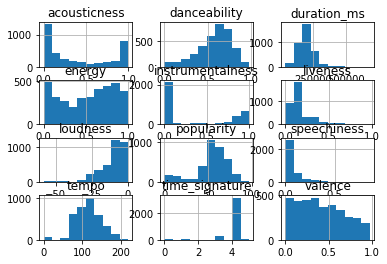

In [30]:
playlists.hist()
plt.show()

A quick glance at the data tells us that some of the columns are skewed.So we may want to look into the possibilty of applying transformations to adjust our data.

In [28]:
playlists.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
count,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000
mean,195401.238279,54.498897,0.395132,0.578668,0.521636,0.330567,0.175147,-11.420158,0.091953,115.776044,3.813293,0.417518
std,56412.652563,18.827745,0.385037,0.199972,0.304854,0.413491,0.147644,9.342298,0.097581,35.250106,0.730158,0.265401
min,42000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-58.555000,0.000000,0.000000,0.000000,0.000000
25%,159433.500000,49.000000,0.039325,0.468000,0.238250,0.000001,0.097100,-15.224000,0.038000,92.259500,4.000000,0.193000
50%,193644.500000,57.000000,0.227000,0.617000,0.574000,0.002805,0.114000,-7.891000,0.051900,118.024000,4.000000,0.385000
75%,226898.000000,66.000000,0.842000,0.723000,0.788000,0.857000,0.194000,-5.139250,0.098900,138.073500,4.000000,0.619750
max,678013.000000,97.000000,0.996000,0.980000,1.000000,1.000000,0.977000,0.101000,0.855000,218.418000,5.000000,0.979000


We see that our numeric columns are on very different scales, so we will definitely have to normalize our columns. Especially if we are going to be using models such as KNN

### So from our preliminary look at the data we learned a couple things:
- We have a good amount of categorical columns, so we will have to perform some type of encoding to transform these categorical values into numerical ones before running our data through a model.
- Each playlist type is well represented, but we have more examples of some than others.
- We don't have null values since we removed them during our extraction and transformation of the data from the Spotify API.
- Our numeric columns are on vastly different scales so we will have to normalize the data if we plan on using certain technique(techniques where the scale/variation of the data matters)
- Some of our numeric columns are skewed so we can explore the possibility of applying transformations to standardize the model.
- Since we concatenated the playlists, they are all in consecutive order. So we will have to shuffle the examples before splitting our set up into a test and training set.

# Create a Test Set

To avoid data snooping, we will separate a test set before continuing our analysis. We will create a training and test csv file so that we don't have to reacquire the data from Spotify. We use Stratefied Shuffle Split to ensure that we have a good mix of each type of playlist in both the test and training set.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(playlists, playlists['playlist_type']):
    train_set = playlists.iloc[train_index]
    test_set = playlists.iloc[test_index]

In [56]:
playlists['playlist_type'].value_counts() / len(playlists)

focus      0.348869
sleep      0.240210
workout    0.217595
party      0.193326
Name: playlist_type, dtype: float64

In [53]:
train_set["playlist_type"].value_counts() / len(train_set)

focus      0.348966
sleep      0.240000
workout    0.217586
party      0.193448
Name: playlist_type, dtype: float64

In [55]:
test_set["playlist_type"].value_counts() / len(test_set)

focus      0.348485
sleep      0.241047
workout    0.217631
party      0.192837
Name: playlist_type, dtype: float64

Using the Stratefied Shuffle Split strategy we were able to generate a training and test set with almost identical playlist_type category proportions as those in the full dataset. Now we can export these dataframes into separate .csv files before continuing our full analysis. 

In [61]:
train_set.to_csv('training_data.csv')

In [62]:
test_set.to_csv('test_data.csv')

We've successfully created our training and test set. We will do all of our exploration and develop our model using the training set, before finally trying it out on our test set.